# Homework 1 (Due Sep 23, 2025 by Noon) 


## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

You've learned how to create L- and M- estimators and use them to estimate the parameters of a model. Generally, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$
You can use one of the estimators we discussed in the lecture, but you should be aware that the dataset can have outliers. 


Once you write down the $\ln L$ in terms of the model parameters, $a$ and $b$, this is the expression that you now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements your favorite robust loss function, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with your likelihood function in the previous part, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [8]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers

data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

In [4]:
data

array([( 1, 201., 592.,  9., 61., -0.84),
       ( 2, 244., 401.,  4., 25.,  0.31),
       ( 3,  47., 583., 11., 38.,  0.64),
       ( 4, 287., 402.,  7., 15., -0.27),
       ( 5, 203., 495.,  5., 21., -0.33),
       ( 6,  58., 173.,  9., 15.,  0.67),
       ( 7, 210., 479.,  4., 27., -0.02),
       ( 8, 202., 504.,  4., 14., -0.05),
       ( 9, 198., 510., 11., 30., -0.84),
       (10, 158., 416.,  7., 16., -0.69),
       (11, 165., 393.,  5., 14.,  0.3 ),
       (12, 201., 442.,  5., 25., -0.46),
       (13, 157., 317.,  5., 52., -0.03),
       (14, 131., 311.,  6., 16.,  0.5 ),
       (15, 166., 400.,  6., 34.,  0.73),
       (16, 160., 337.,  5., 31., -0.52),
       (17, 186., 423.,  9., 42.,  0.9 ),
       (18, 125., 334.,  8., 26.,  0.4 ),
       (19, 218., 533.,  6., 16., -0.78),
       (20, 146., 344.,  5., 22., -0.56)],
      dtype=[('ID', '<i4'), ('x', '<f8'), ('y', '<f8'), ('sigma_x', '<f8'), ('sigma_y', '<f8'), ('rho_xy', '<f8')])

### Part 1

In [6]:
def model(a, x, b):
    return a * x + b

def squared_loss(params, x, y, dy = 1):
    a, b = params
    resid = y - model(a, x, b)
    return np.sum((resid/dy)**2)

### Part 2

In [14]:
import sys
sys.maxsize
x.min()

47.0

In [19]:
a_vals = np.linspace(0, y.max(), sys.maxsize)
b_vals = np.linspace(0, y.max(), sys.maxsize)

best_ll = -np.inf
best_a, best_b = None, None

for a in a_vals:
    for b in b_vals:
        ll = squared_loss((a, b), x, y, dy)
        if ll > best_ll:
            best_ll = ll
            best_a, best_b = a, b

print(f"Best-fit slope a = {best_a:.3f}")
print(f"Best-fit intercept b = {best_b:.3f}")
print(f"Maximum log-likelihood = {best_ll:.2f}")

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

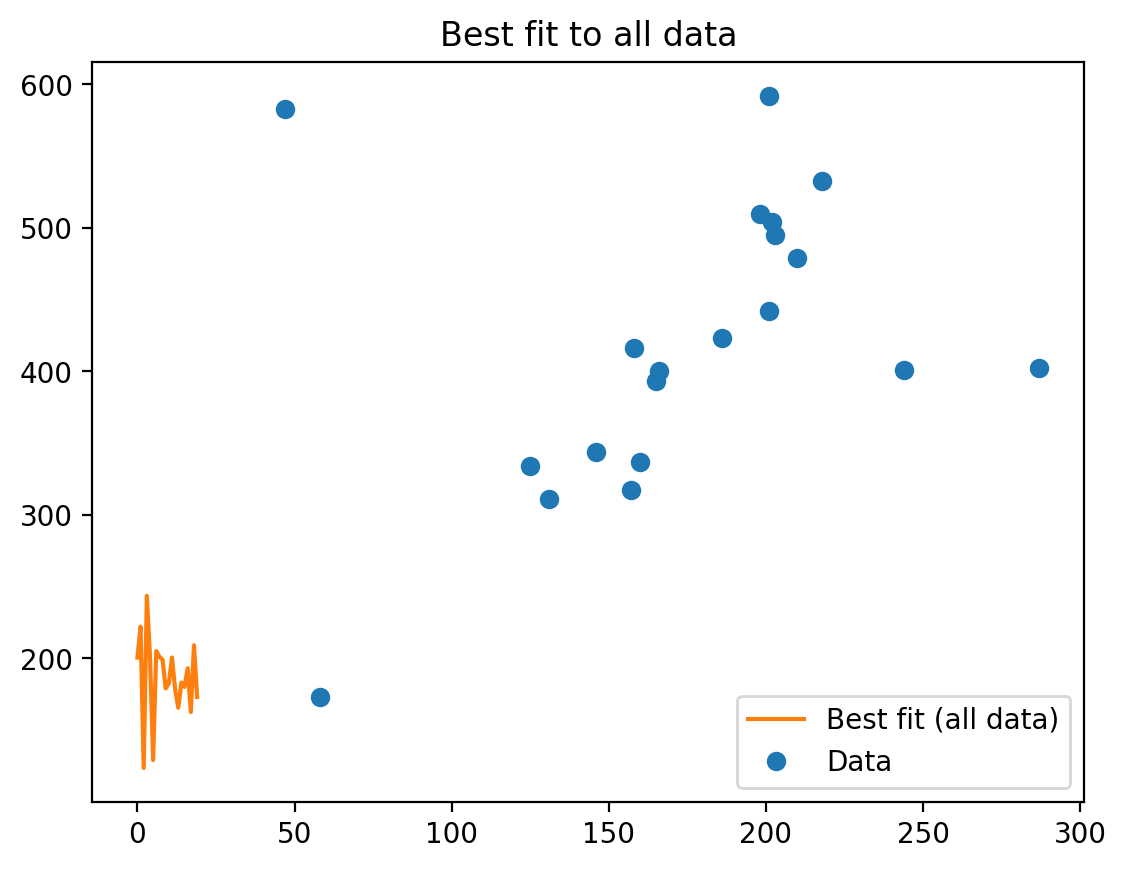

In [9]:
plt.plot(best_a * x + best_b, color='C1', label='Best fit (all data)')
plt.plot(x, y, 'o', label='Data')
plt.title("Best fit to all data")
plt.legend()
plt.show()

### Part 3

In [57]:
def sigma_clip(x, y, dy, a_init, b_init, nsig):
    resid = y - model(a_init, x, b_init)
    sigma_resid = np.std(resid)
    mask = np.abs(resid) < nsig * sigma_resid
    return mask

# First fit
a0, b0 = best_a, best_b

# Sigma clip
mask = sigma_clip(x, y, dy, a0, b0, nsig=1)
x_clip, y_clip, dy_clip = x[mask], y[mask], dy[mask]

# Refit using squared loss grid on clipped data
# Same method as before
a_vals = np.linspace(0.5, 1.5, 201)
b_vals = np.linspace(100, 300, 201)
best_ll, best_a_clip, best_b_clip = -np.inf, None, None

for a in a_vals:
    for b in b_vals:
        ll = squared_loss((a, b), x_clip, y_clip, dy_clip)
        if ll > best_ll:
            best_ll, best_a_clip, best_b_clip = ll, a, b

print(f"Sigma-clipped fit: a = {best_a_clip:.3f}, b = {best_b_clip:.3f}")

Sigma-clipped fit: a = 1.500, b = 158.000


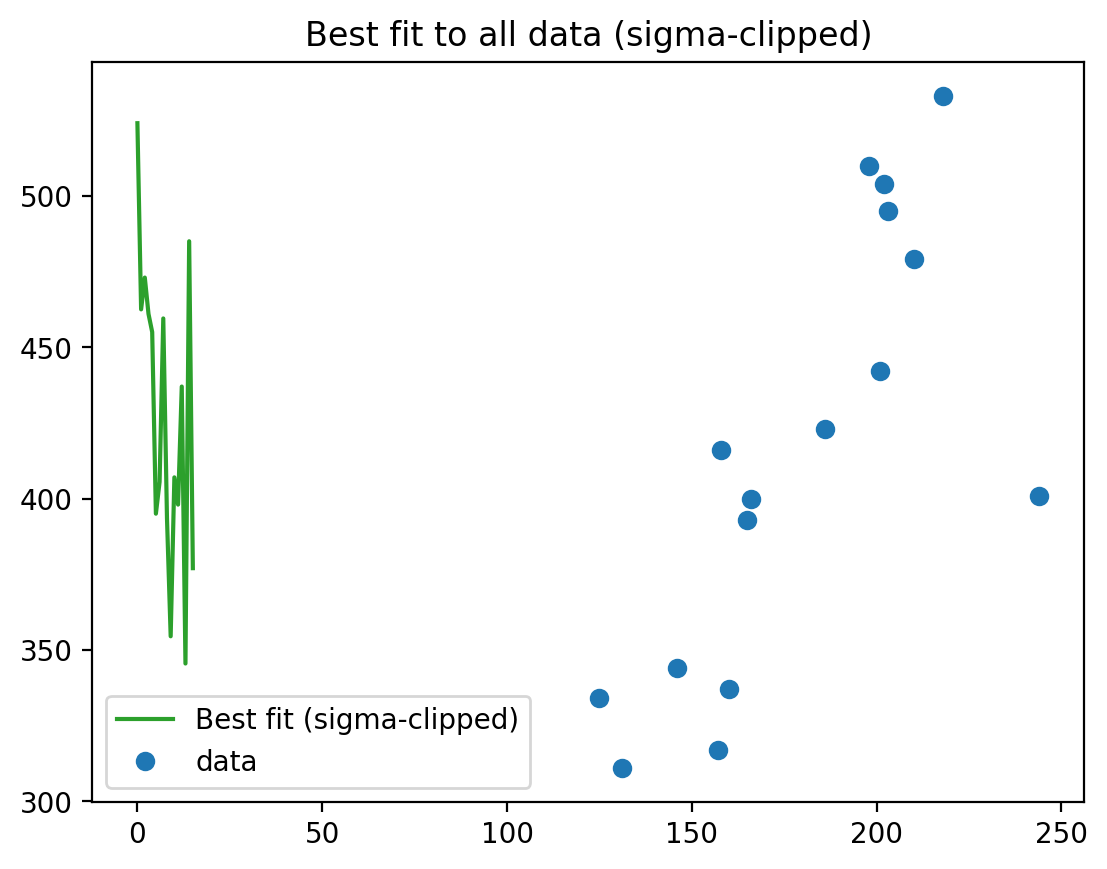

In [58]:
plt.plot(best_a_clip * x_clip + best_b_clip, color='C2', label='Best fit (sigma-clipped)')
plt.plot(x_clip, y_clip, 'o', label='data')
plt.title("Best fit to all data (sigma-clipped)")
plt.legend()
plt.show()

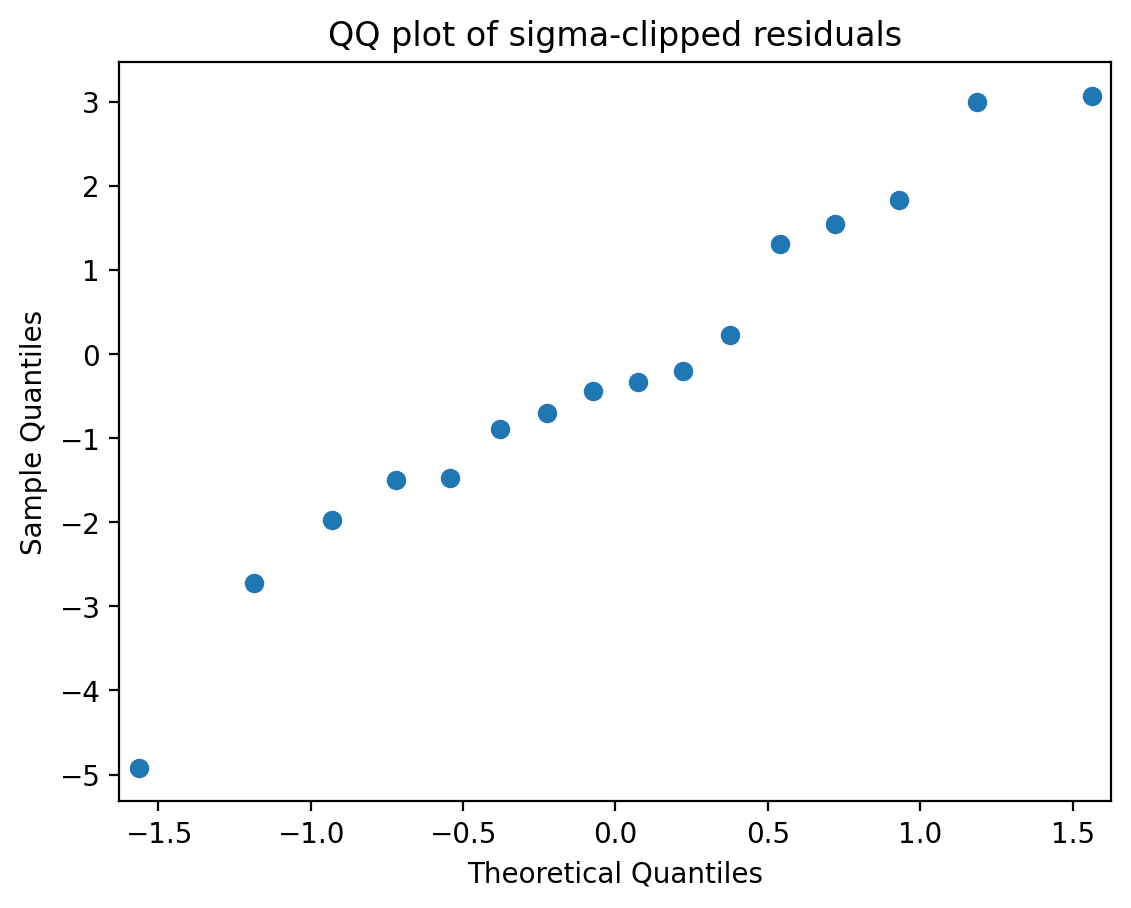

In [59]:
# QQ plot of residuals
resid_clip = (y_clip - model(best_a_clip, x_clip, best_b_clip)) / dy_clip
sm.qqplot(resid_clip)
plt.title("QQ plot of sigma-clipped residuals")
plt.show()

### Part 4

In [67]:
def log_likelihood_cauchy(a, b, x, y, dy):
    resid = (y - model(a, x, b)) / dy
    return -np.sum(np.log(1 + resid**2))
def neg_loglik_cauchy(params, x, y, dy):
    a, b = params
    return -log_likelihood_cauchy(a, b, x, y, dy)

### Part 5

Optimization terminated successfully.
         Current function value: 26.884062
         Iterations: 57
         Function evaluations: 109
Robust Cauchy fit: a = 2.199, b = 40.461


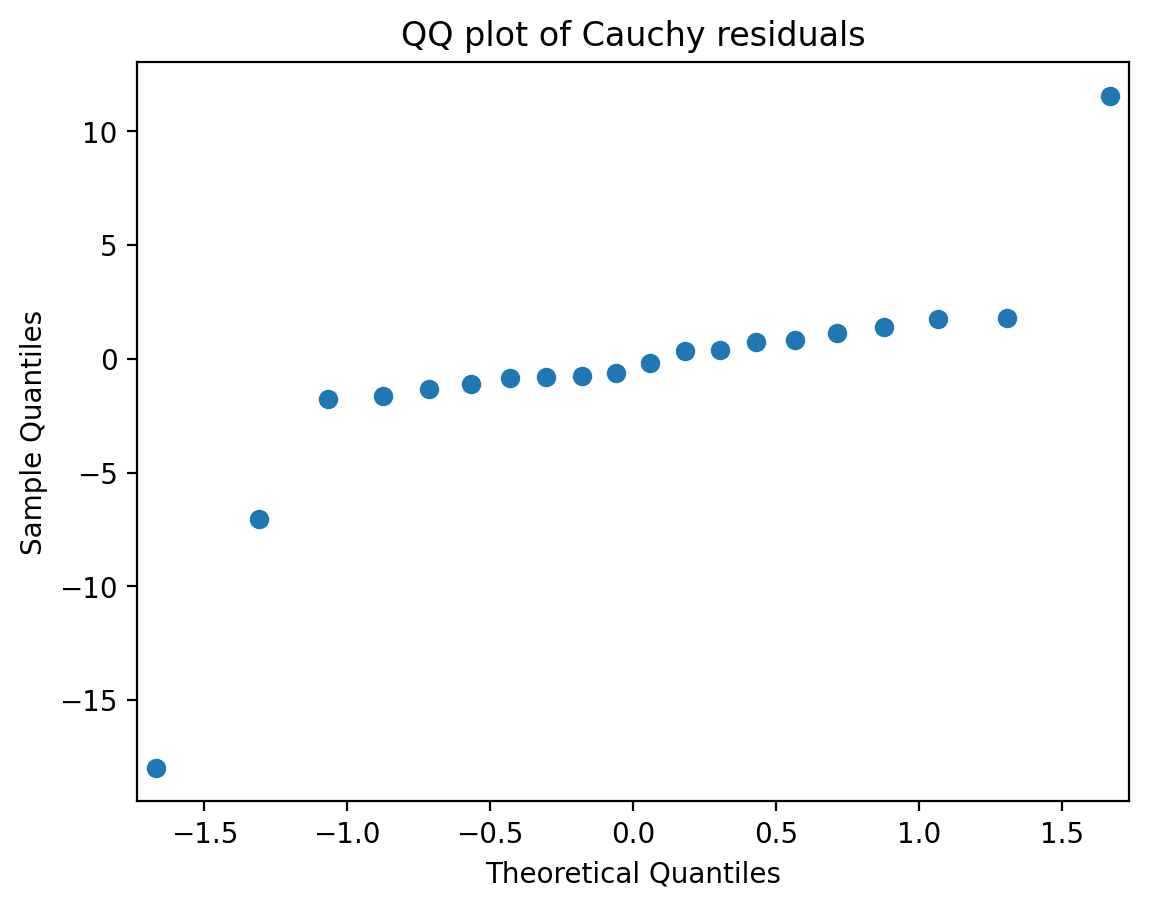

In [68]:
res = scipy.optimize.fmin(neg_loglik_cauchy, x0=[1.0, 200.0], args=(x, y, dy))
a_robust, b_robust = res
print(f"Robust Cauchy fit: a = {a_robust:.3f}, b = {b_robust:.3f}")

# QQ plot
resid_robust = (y - model(a_robust, x, b_robust)) / dy
sm.qqplot(resid_robust)
plt.title("QQ plot of Cauchy residuals")
plt.show()

# Problem 2
The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids.

These stars are awesome because you can use them to measure distances. Here's a nice youtube video on these stars.

You'll try to estimate their period-luminosity relationship.

The Wesenheit index is defined as W = I - 1.55(V - I), and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns.

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.

- Split the data into LMC and SMC, and then again by mode F and 1, and plot the W on the y-axis vs log(P1) on x. Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

- Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

- Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

- Finally, plot the residuals against the fitted W values, and just to anticipate the next homework assignment, also plot log(P1) vs V-I. Comment on what you are seeing. (15 pts)

In [71]:
cepheids = pd.read_csv("Cepheids.csv")
print(cepheids.dtypes)
cepheids

name      object
RA0      float64
Decl0    float64
Mode      object
Cloud     object
W        float64
logP1    float64
VI       float64
dtype: object


,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
0,OGLE-LMC-CEP-0002,4.529733,-69.819330,F,LMC,14.52500,0.493893,0.740
1,OGLE-LMC-CEP-0005,4.592089,-69.734970,F,LMC,13.49540,0.749122,0.752
2,OGLE-LMC-CEP-0012,4.630203,-67.214420,F,LMC,14.54210,0.424912,0.598
3,OGLE-LMC-CEP-0016,4.642367,-67.646310,F,LMC,12.03300,1.021456,1.080
4,OGLE-LMC-CEP-0017,4.649119,-69.688390,F,LMC,14.34215,0.565524,0.647
...,...,...,...,...,...,...,...,...
7264,OGLE-SMC-CEP-4622,1.404808,-73.269361,1,SMC,15.94460,0.141140,0.648
7265,OGLE-SMC-CEP-4624,1.406767,-74.192639,1,SMC,15.29565,0.102449,0.577
7266,OGLE-SMC-CEP-4625,1.407181,-72.936056,1,SMC,15.33725,0.074740,0.485
7267,OGLE-SMC-CEP-4627,1.413575,-72.599167,1,SMC,14.06670,0.501477,0.686


In [72]:
cepheidsLMC = cepheids[cepheids["name"].str.slice(5, 8) == 'LMC']
cepheidsSMC = cepheids[cepheids["name"].str.slice(5, 8) == 'SMC']
print(len(cepheidsLMC), len(cepheidsSMC), len(cepheidsLMC)+len(cepheidsSMC) == len(cepheids))

3034 4235 True


In [75]:
cepheidsLMC_Mode1 = cepheidsLMC[cepheidsLMC["Mode"] == '1']
cepheidsLMC_ModeF = cepheidsLMC[cepheidsLMC["Mode"] == 'F']

cepheidsSMC_Mode1 = cepheidsSMC[cepheidsSMC["Mode"] == '1']
cepheidsSMC_ModeF = cepheidsSMC[cepheidsSMC["Mode"] == 'F']

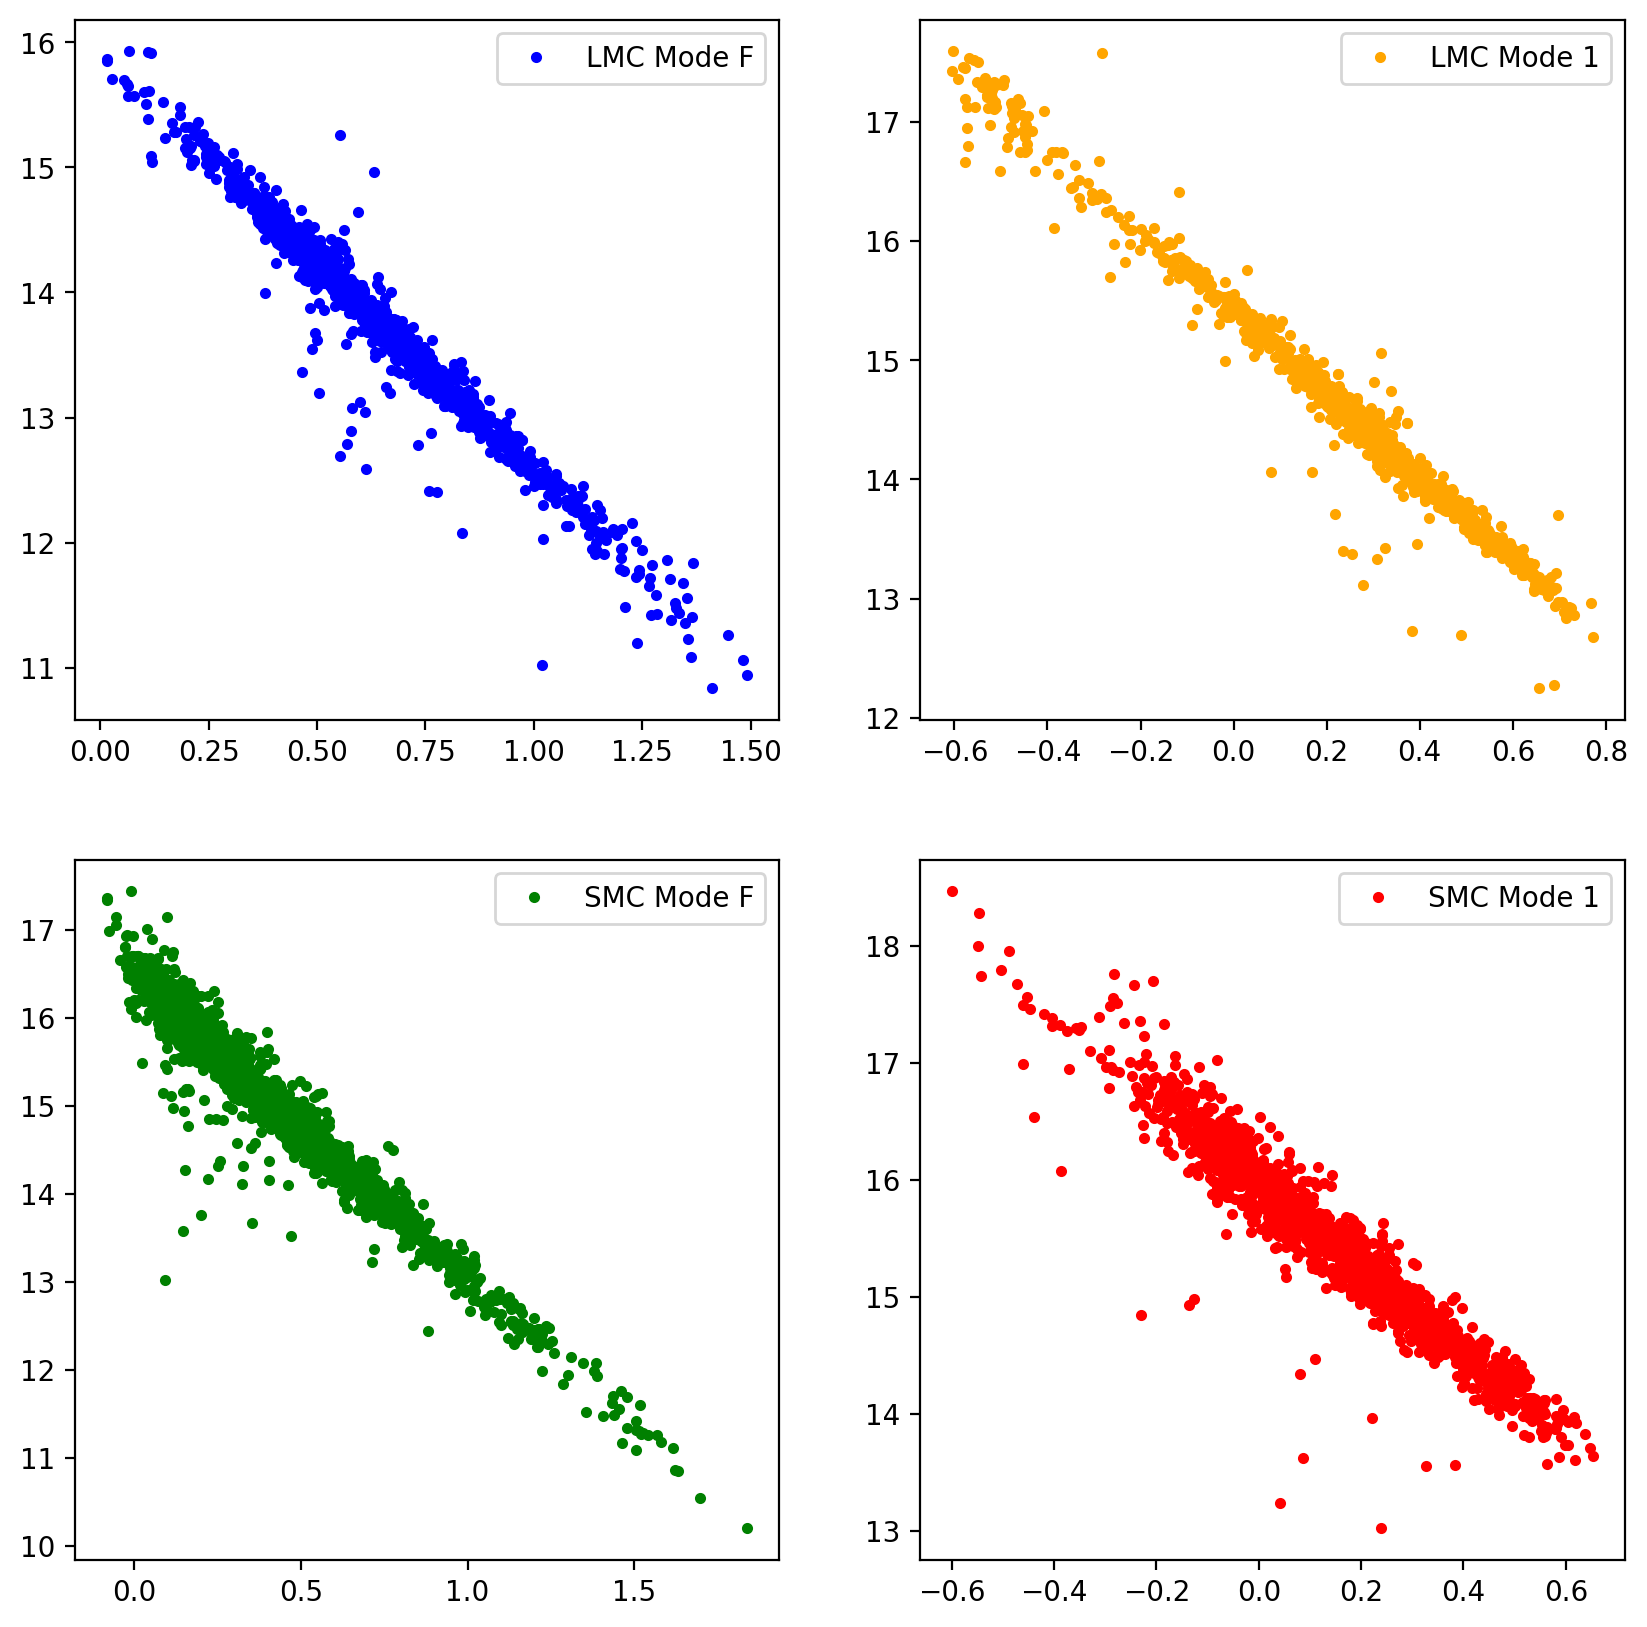

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))

ax[0, 0].plot(cepheidsLMC_ModeF["logP1"], cepheidsLMC_ModeF["W"], '.', label = "LMC Mode F", c = 'blue')
ax[0, 1].plot(cepheidsLMC_Mode1["logP1"], cepheidsLMC_Mode1["W"], '.', label = "LMC Mode 1", c = 'orange')

ax[1, 0].plot(cepheidsSMC_ModeF["logP1"], cepheidsSMC_ModeF["W"], '.', label = "SMC Mode F", c = 'green')
ax[1, 1].plot(cepheidsSMC_Mode1["logP1"], cepheidsSMC_Mode1["W"], '.', label = "SMC Mode 1", c = 'red')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
plt.show()

In [90]:
# Fitting straight lines to each subset
def fit_line(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    b, a = model.params
    return a, b, model

fits = {}

for label, subset in {
    "LMC-F": cepheidsLMC_ModeF,
    "LMC-1": cepheidsLMC_Mode1,
    "SMC-F": cepheidsSMC_ModeF,
    "SMC-1": cepheidsSMC_Mode1
}.items():
    a, b, model = fit_line(subset["logP1"], subset["W"])
    fits[label] = {"a": a, "b": b, "model": model}

In [91]:
# Residuals for each subset
for label, subset in {
    "LMC-F": cepheidsLMC_ModeF,
    "LMC-1": cepheidsLMC_Mode1,
    "SMC-F": cepheidsSMC_ModeF,
    "SMC-1": cepheidsSMC_Mode1
}.items():
    a, b = fits[label]["a"], fits[label]["b"]
    yhat = a * subset["logP1"] + b
    resid = subset["W"] - yhat
    fits[label]["resid"] = resid
    fits[label]["yhat"] = yhat

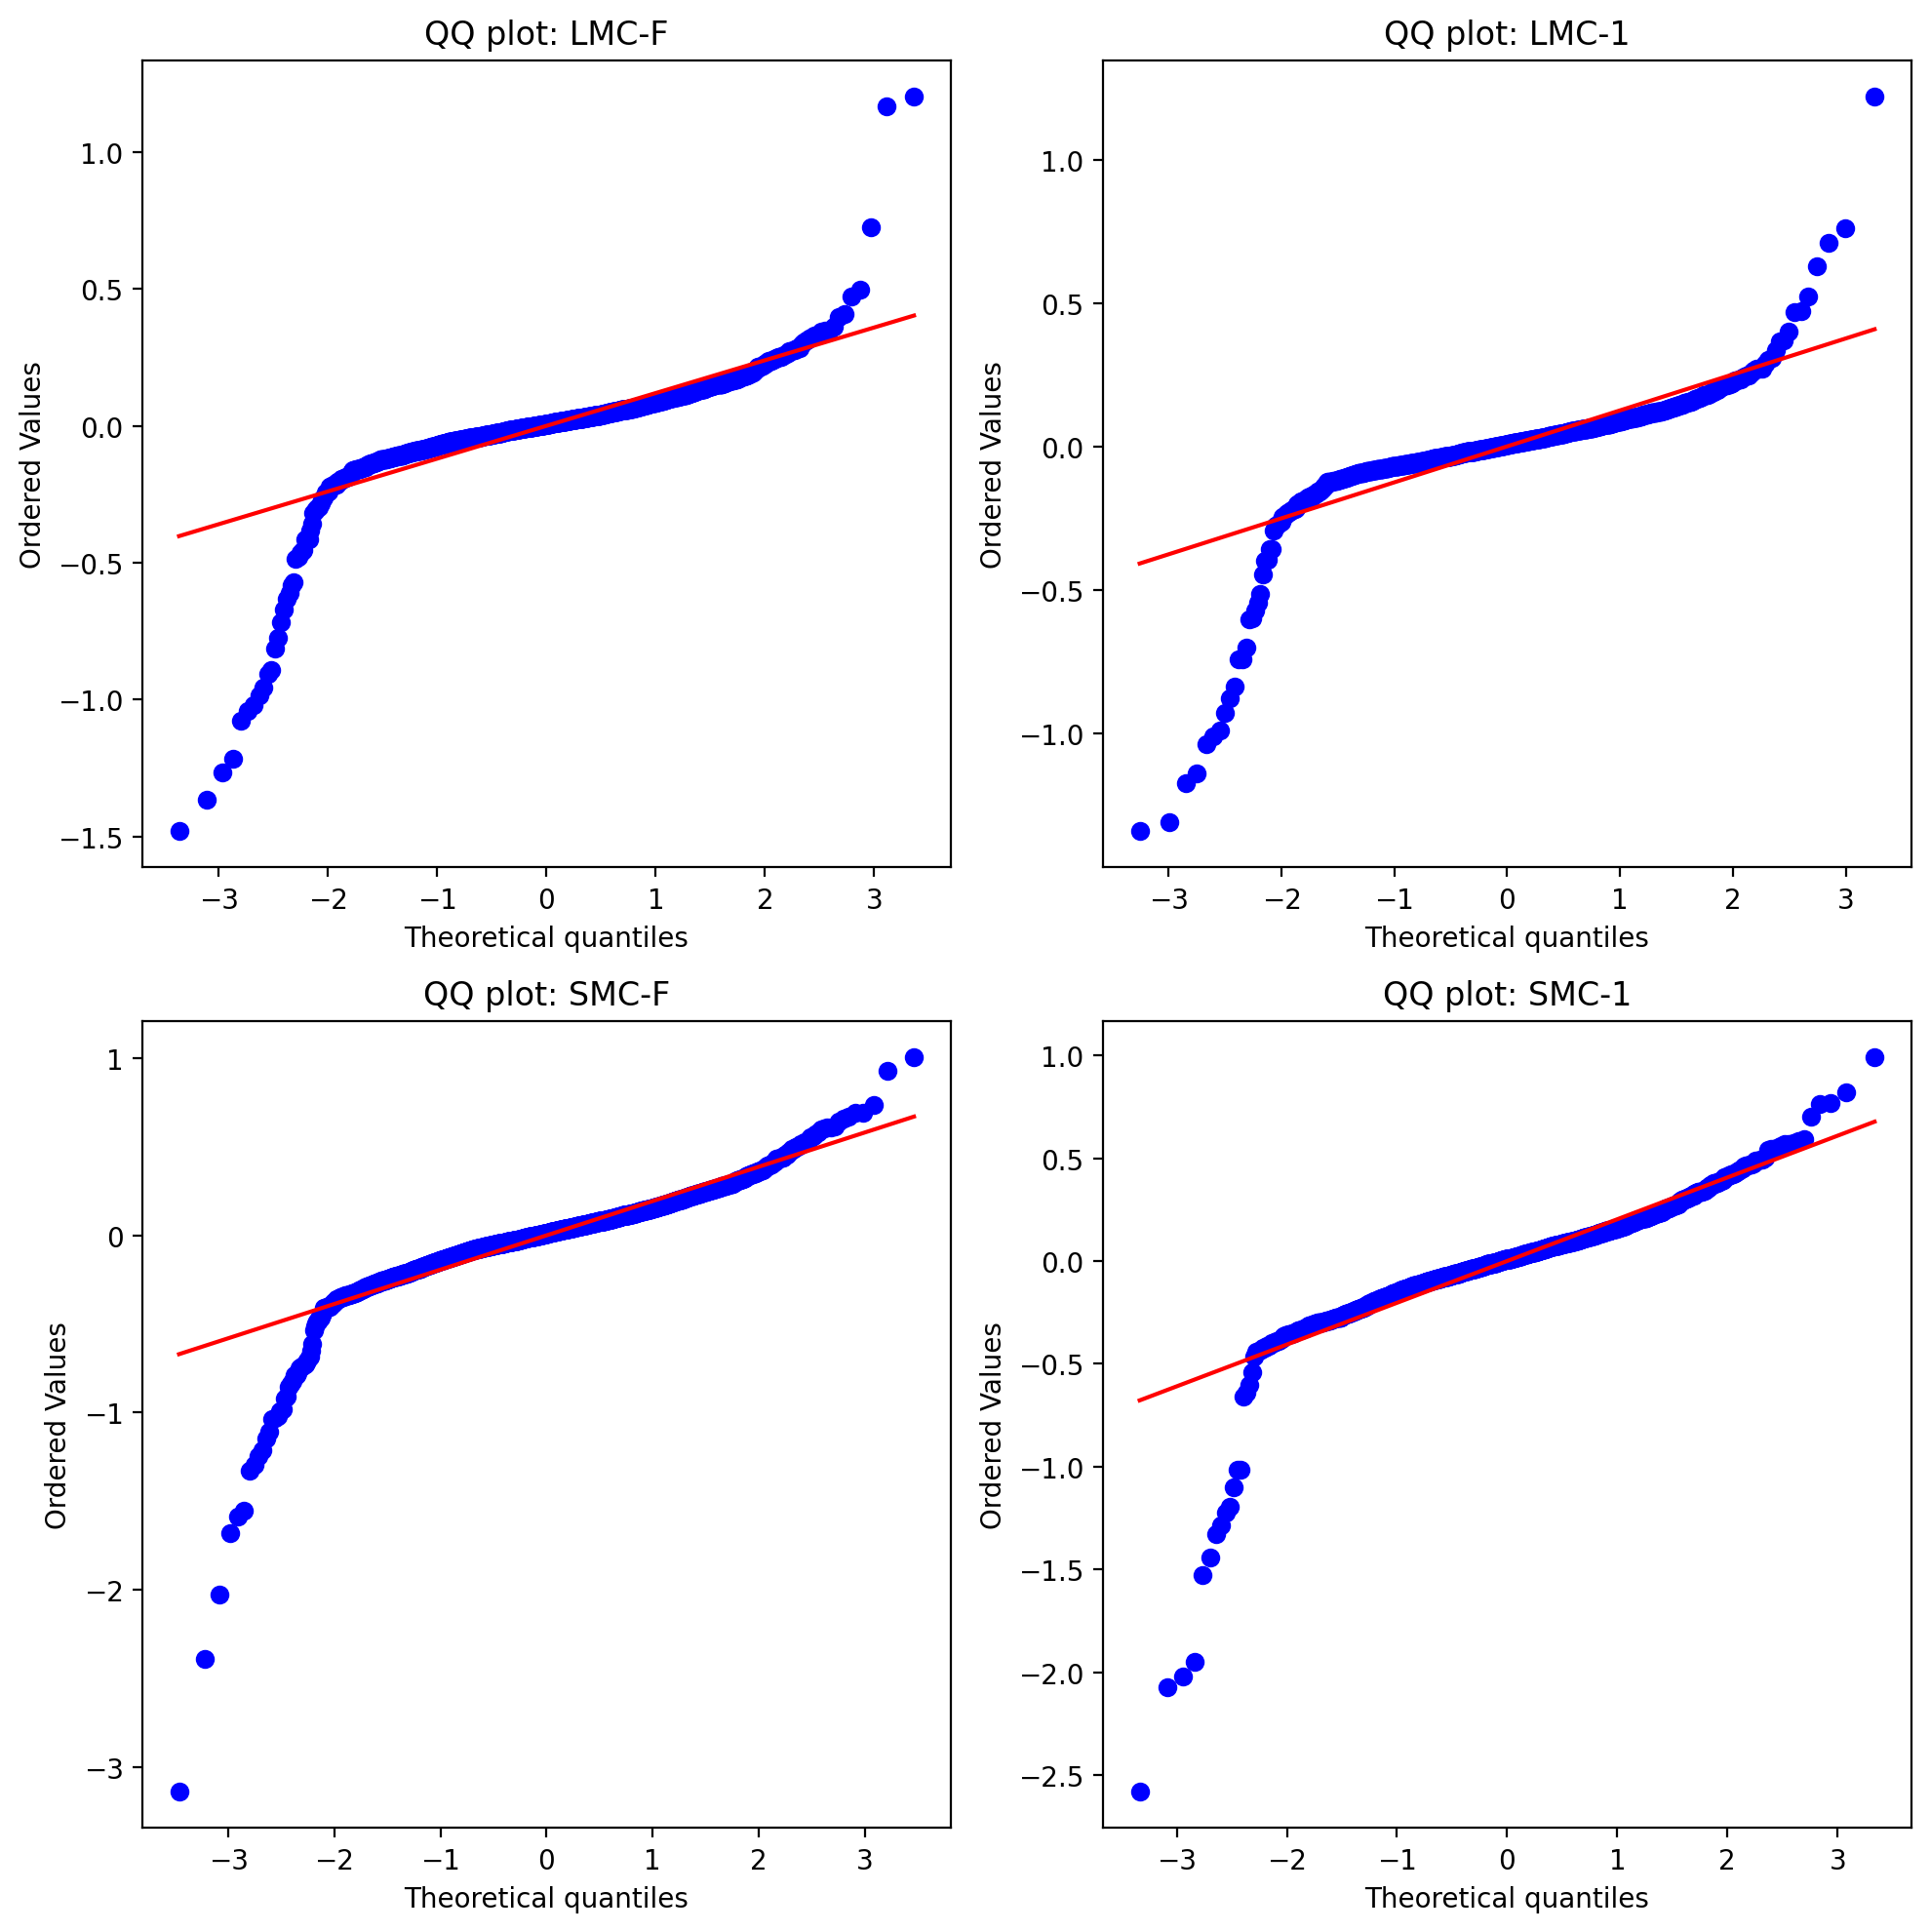

In [102]:
## Check if residuals look normal
from scipy.stats import probplot

fig, axs = plt.subplots(2,2, figsize=(10,10))
for ax, (label, d) in zip(axs.ravel(), fits.items()):
    probplot(d["resid"], dist="norm", plot=ax)
    ax.set_title(f"QQ plot: {label}")
plt.tight_layout()
plt.show()

Thoughts:

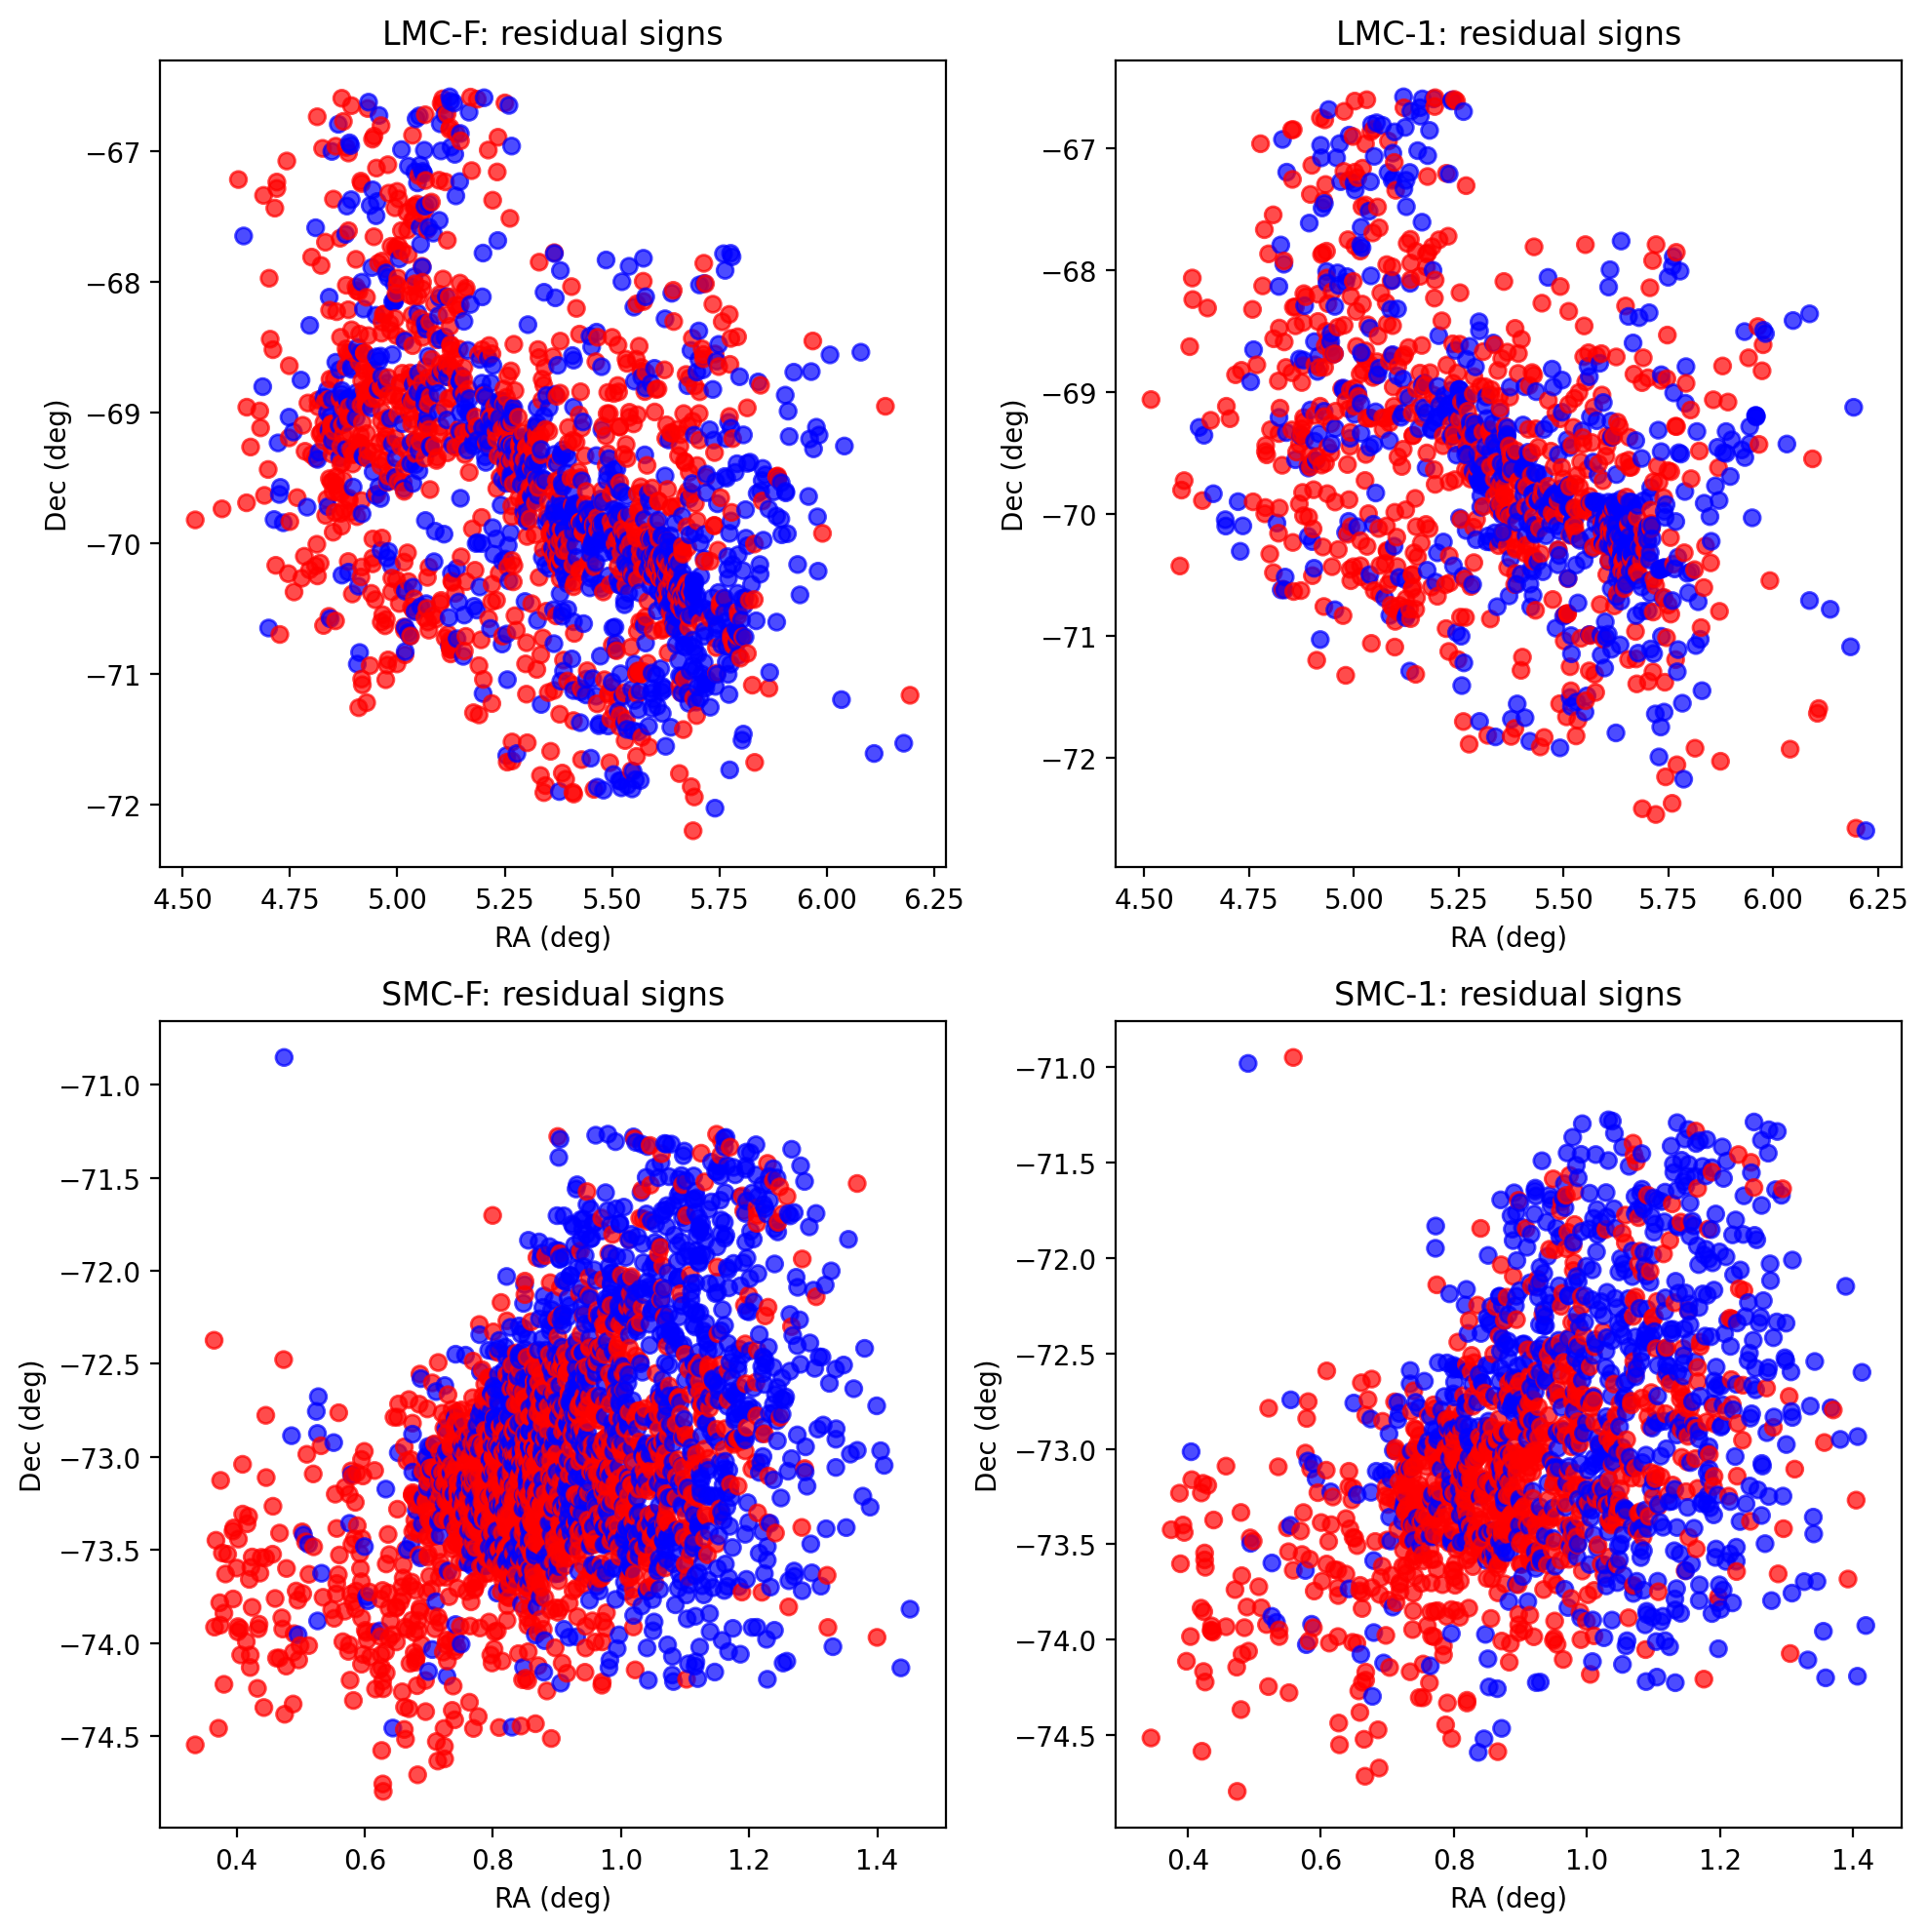

In [103]:
## Residuals color coded
fig, axs = plt.subplots(2,2, figsize=(10,10))
for ax, (label, subset) in zip(axs.ravel(), {
    "LMC-F": cepheidsLMC_ModeF,
    "LMC-1": cepheidsLMC_Mode1,
    "SMC-F": cepheidsSMC_ModeF,
    "SMC-1": cepheidsSMC_Mode1
}.items()):
    resid = fits[label]["resid"]
    ax.scatter(subset["RA0"], subset["Decl0"], c=np.sign(resid), cmap="bwr", alpha=0.7)
    ax.set_title(f"{label}: residual signs")
    ax.set_xlabel("RA (deg)")
    ax.set_ylabel("Dec (deg)")
plt.tight_layout()
plt.show()

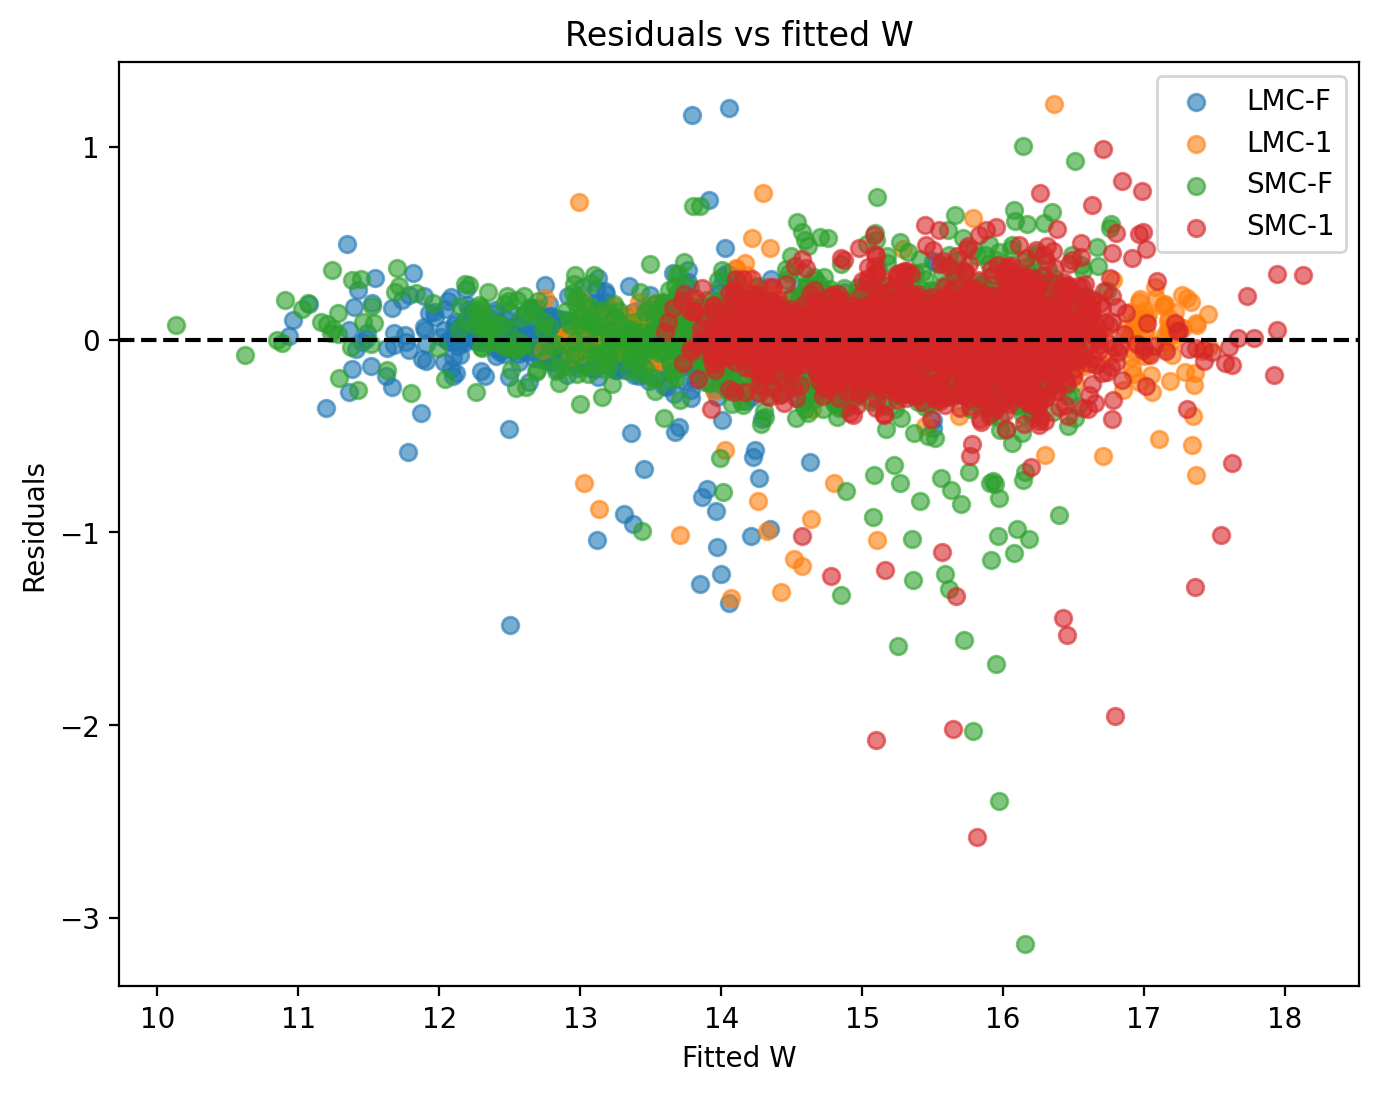

In [106]:
## Residuals vs fitted W

# Residuals vs fitted W
plt.figure(figsize=(8,6))
for label, subset in {
    "LMC-F": cepheidsLMC_ModeF,
    "LMC-1": cepheidsLMC_Mode1,
    "SMC-F": cepheidsSMC_ModeF,
    "SMC-1": cepheidsSMC_Mode1
}.items():
    plt.scatter(fits[label]["yhat"], fits[label]["resid"], label=label, alpha=0.6)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Fitted W")
plt.ylabel("Residuals")
plt.legend()
plt.title("Residuals vs fitted W")
plt.show()

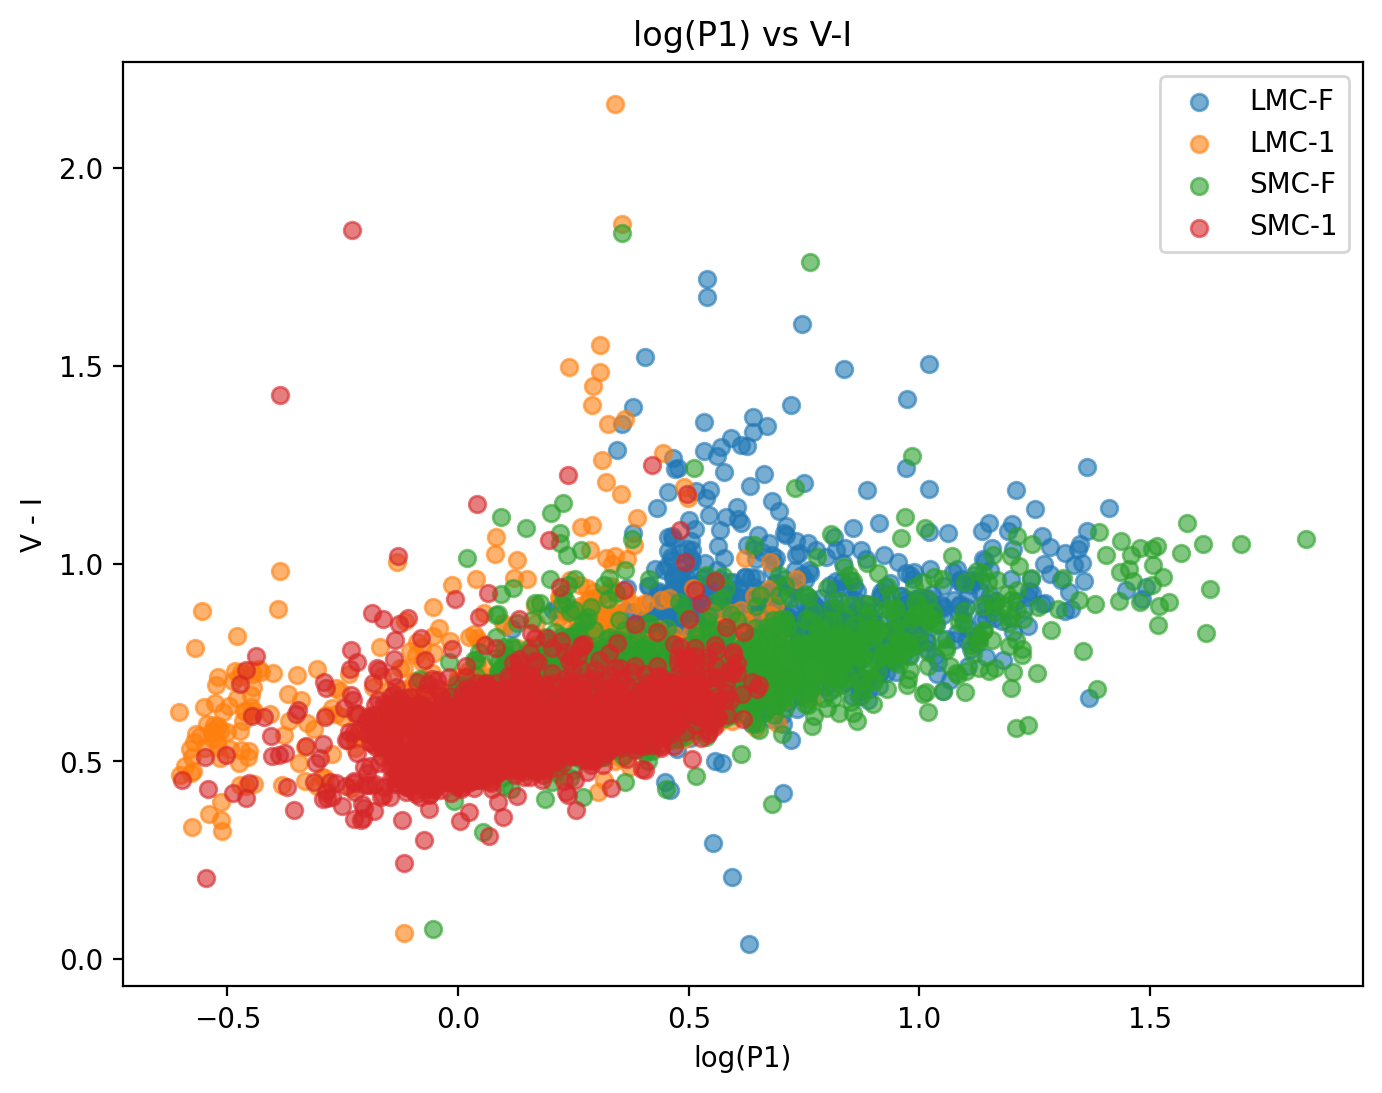

In [107]:
# log(P1) vs V-I
plt.figure(figsize=(8,6))
for label, subset in {
    "LMC-F": cepheidsLMC_ModeF,
    "LMC-1": cepheidsLMC_Mode1,
    "SMC-F": cepheidsSMC_ModeF,
    "SMC-1": cepheidsSMC_Mode1
}.items():
    plt.scatter(subset["logP1"], subset["VI"], label=label, alpha=0.6)
plt.xlabel("log(P1)")
plt.ylabel("V - I")
plt.legend()
plt.title("log(P1) vs V-I")
plt.show()

Thoughts: